In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

folder = "colab/pytorch"
project_dir = "dnn"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/colab/pytorch/01_dnn_pt


In [ ]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 1.12.0+cu113


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.12.0+cu113
GPU 사용 가능 여부: True


In [ ]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

In [ ]:
from torch.utils.data import DataLoader

root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

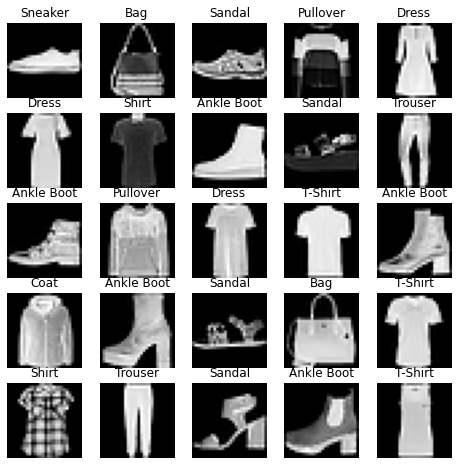

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 512),   
            nn.BatchNorm1d(512),    
            nn.ReLU()     
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512,10)    
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear): 
        nn.init.xavier_normal_(m.weight) 
        print(m.weight)

In [ ]:
torch.manual_seed(7777)
model = DNN().to(device)
model.apply(weights_init)

Parameter containing:
tensor([[-0.0113, -0.0095, -0.0257,  ..., -0.0324,  0.0534, -0.0091],
        [-0.0407,  0.0350, -0.0196,  ..., -0.0266,  0.0307,  0.0381],
        [-0.0205,  0.0367,  0.0094,  ..., -0.0310, -0.0451,  0.0051],
        ...,
        [ 0.0224,  0.0218,  0.0649,  ..., -0.0711,  0.0516,  0.0244],
        [-0.0069,  0.0066, -0.0228,  ...,  0.0111,  0.0148, -0.0265],
        [ 0.0097,  0.0041,  0.0480,  ...,  0.0044, -0.0069,  0.0417]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0278,  0.1138, -0.0497,  ...,  0.0713, -0.1142, -0.0279],
        [ 0.1104,  0.1485,  0.0111,  ..., -0.0413, -0.0416, -0.0403],
        [ 0.0723,  0.0004,  0.0527,  ..., -0.0378, -0.0192,  0.0166],
        ...,
        [ 0.0913, -0.0038, -0.0674,  ...,  0.0191,  0.0053,  0.0374],
        [-0.0781, -0.0059, -0.0229,  ..., -0.0934,  0.0464, -0.0997],
        [ 0.0680,  0.0889, -0.1250,  ..., -0.0719,  0.0563,  0.0140]],
       device='cuda:0', requires_grad=True)


DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)  
        loss = criterion(outputs, labels)     
        
        optimizer.zero_grad()           
        loss.backward()          
        optimizer.step()          
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.3905, Accuracy: 88.00%
Epoch [1/5], Step [200/600], Loss: 0.4790, Accuracy: 82.00%
Epoch [1/5], Step [300/600], Loss: 0.3281, Accuracy: 89.00%
Epoch [1/5], Step [400/600], Loss: 0.2909, Accuracy: 90.00%
Epoch [1/5], Step [500/600], Loss: 0.4960, Accuracy: 89.00%
Epoch [1/5], Step [600/600], Loss: 0.2986, Accuracy: 85.00%
Epoch [2/5], Step [100/600], Loss: 0.3353, Accuracy: 89.00%
Epoch [2/5], Step [200/600], Loss: 0.3538, Accuracy: 89.00%
Epoch [2/5], Step [300/600], Loss: 0.5331, Accuracy: 79.00%
Epoch [2/5], Step [400/600], Loss: 0.2347, Accuracy: 94.00%
Epoch [2/5], Step [500/600], Loss: 0.3652, Accuracy: 85.00%
Epoch [2/5], Step [600/600], Loss: 0.2906, Accuracy: 92.00%
Epoch [3/5], Step [100/600], Loss: 0.3101, Accuracy: 88.00%
Epoch [3/5], Step [200/600], Loss: 0.1322, Accuracy: 98.00%
Epoch [3/5], Step [300/600], Loss: 0.2561, Accuracy: 90.00%
Epoch [3/5], Step [400/600], Loss: 0.3420, Accuracy: 88.00%
Epoch [3/5], Step [500/600], Loss: 0.284

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 88.30%


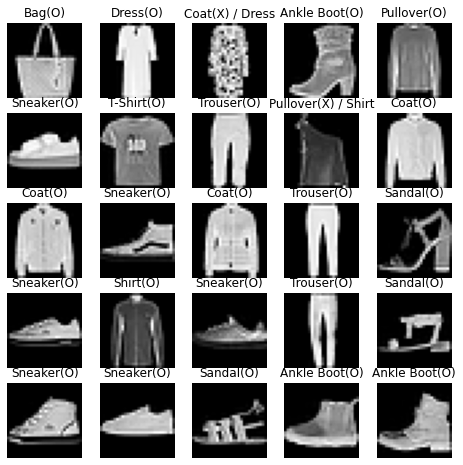

In [ ]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()